# №7 Тип закупки (обычная vs интернет-заказ)

**Формулировка гипотезы**  

H₀: Средний чек одинаков для обычных покупок (в аптеке) и интернет-заказов.   
H₁: Средний чек статистически различается между типами закупки.

**Тесты**
- Welch t-test (на логарифмически преобразованных данных)
    - Размер эффекта Cohen's d
- Mann–Whitney U test 
    - Размер эффекта Cliff’s Delta 

### Загрузка данных

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
import configparser
from scipy import stats
from scipy.stats import skew, kurtosis
 # Импортируем класс из файла db_connection.py
from db_connection import PostgresConnection
# Импортируем класс из файла data_cleaner.py
from data_cleaner import DataCleaner

In [2]:
# Создаем объект для работы с базой данных
db_connection = PostgresConnection()

query = 'SELECT * FROM sales'
data = db_connection.execute_query(query)

### Подготовка данных

In [3]:
# Создаем объект DataCleaner с данным DataFrame
cleaner = DataCleaner(data)

# Удаляем строки с отрицательными значениями в 'dr_sdisc' и 'dr_kol'
cleaned_data = cleaner.drop_negative_values()

# Удаляем строки, где 'dr_nchk' имеет значения из списка [21, 593, 2495]
cleaned_data = cleaner.drop_error_check_values()

In [4]:
cleaned_data['price_without_discount'] = cleaned_data['dr_croz'] * cleaned_data['dr_kol']
grouped = cleaned_data.groupby(['dr_tabempl', 'dr_apt', 'dr_nchk', 'dr_dat']).agg({'price_without_discount':'sum',\
                                                            'dr_sdisc':'max', 'dr_tpay':'max', 'dr_vzak':'max'}).reset_index()
grouped['final_price'] = grouped['price_without_discount'] - grouped['dr_sdisc']
grouped.head()

,dr_tabempl,dr_apt,dr_nchk,dr_dat,price_without_discount,dr_sdisc,dr_tpay,dr_vzak,final_price
0,15,11,2491,2022-05-03,8706.0,0.0,15,2,8706.0
1,15,11,2497,2022-05-04,2677.0,0.0,18,2,2677.0
2,15,11,2499,2022-05-04,2150.0,0.0,18,2,2150.0
3,15,11,2501,2022-05-04,959.0,0.0,18,2,959.0
4,15,11,2503,2022-05-04,1194.0,0.0,18,2,1194.0


### EDA

**Статистика по группам**

In [5]:
# 1. Статистика 
grouped.groupby('dr_vzak')['final_price'].agg(
    mean='mean',
    median='median',
    count='count'
).reset_index().round(2)

,dr_vzak,mean,median,count
0,1,552.34,302.09,20269
1,2,1478.73,1053.00,713


**Визуализация распределений**

dr_vzak
1    20269
2      713
Name: count, dtype: int64


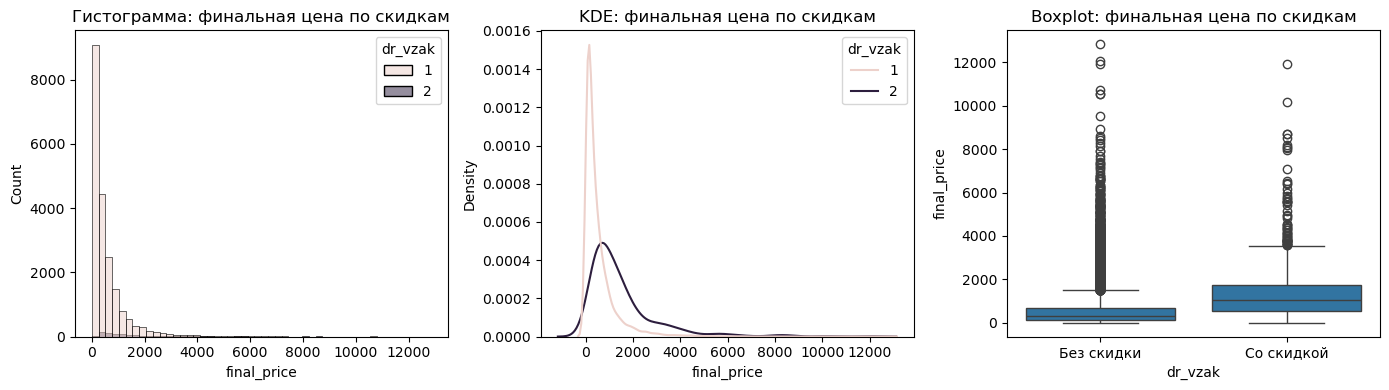

In [6]:
# 2. Проверим распределение по группам
print(grouped["dr_vzak"].value_counts())

# 3. Визуализации
plt.figure(figsize=(14, 4))

# 1. -- Гистограмма
plt.subplot(1, 3, 1)
sns.histplot(data=grouped, x="final_price", hue="dr_vzak", kde=False, bins=50)
plt.title("Гистограмма: финальная цена по скидкам")

# 2. -- KDE (плотность распределения)
plt.subplot(1, 3, 2)
sns.kdeplot(data=grouped, x="final_price", hue="dr_vzak", common_norm=False)
plt.title("KDE: финальная цена по скидкам")

# 3. -- Boxplot
plt.subplot(1, 3, 3)
sns.boxplot(data=grouped, x="dr_vzak", y="final_price")
plt.title("Boxplot: финальная цена по скидкам")
plt.xticks([0, 1], ["Без скидки", "Со скидкой"])

plt.tight_layout()
plt.show()

Оба распределения:
- асимметричны вправо (положительная асимметрия).
- имеют много выбросов, что видно по boxplot'у.
- KDE-график показывает, что группа со скидкой (2) имеет более "растянутый хвост", но общая форма у них схожая — пик в районе 500 – 1000 и длинный хвост вправо.
- На гистограмме видно, что у группы без скидки чаще встречаются более низкие цены.

Формы распределений достаточно схожи, несмотря на различия в масштабе и "хвостах".

## Welch t-test

### Лог-преобразование

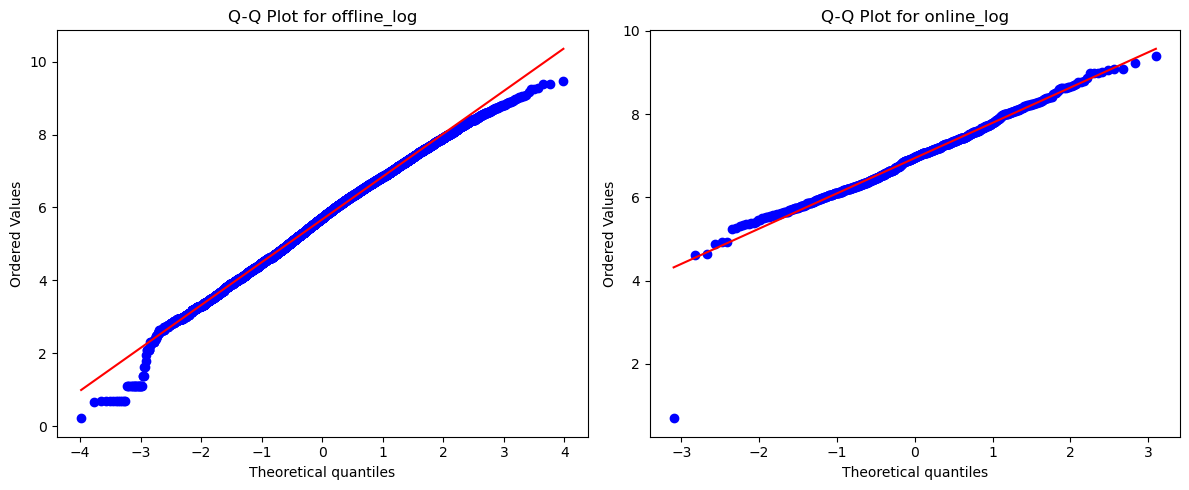

In [7]:
# 1. Лог-преобразование (добавляем +1, чтобы избежать log(0))
grouped["log_final_price"] = np.log1p(grouped["final_price"])

# 2. Делим на группы: со скидкой vs без скидки
offline_log = grouped.loc[grouped["dr_vzak"] == 1, "log_final_price"]
online_log = grouped.loc[grouped["dr_vzak"] == 2, "log_final_price"]

# Создание фигуры и осей
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Первый график Q-Q
stats.probplot(offline_log, dist="norm", plot=axes[0])
axes[0].set_title("Q-Q Plot for offline_log")

# Второй график Q-Q
stats.probplot(online_log, dist="norm", plot=axes[1])
axes[1].set_title("Q-Q Plot for online_log")

# Настройка и показ графиков
fig.tight_layout()
plt.show()

Для оценки нормальности распределений логарифмически преобразованных значений чеков по типам закупки были построены Q-Q графики. 
- Распределение для группы offline демонстрирует умеренное приближение к нормальному с отклонениями в нижнем хвосте.
- Распределение для группы online значительно ближе к нормальному, за исключением незначительных выбросов.

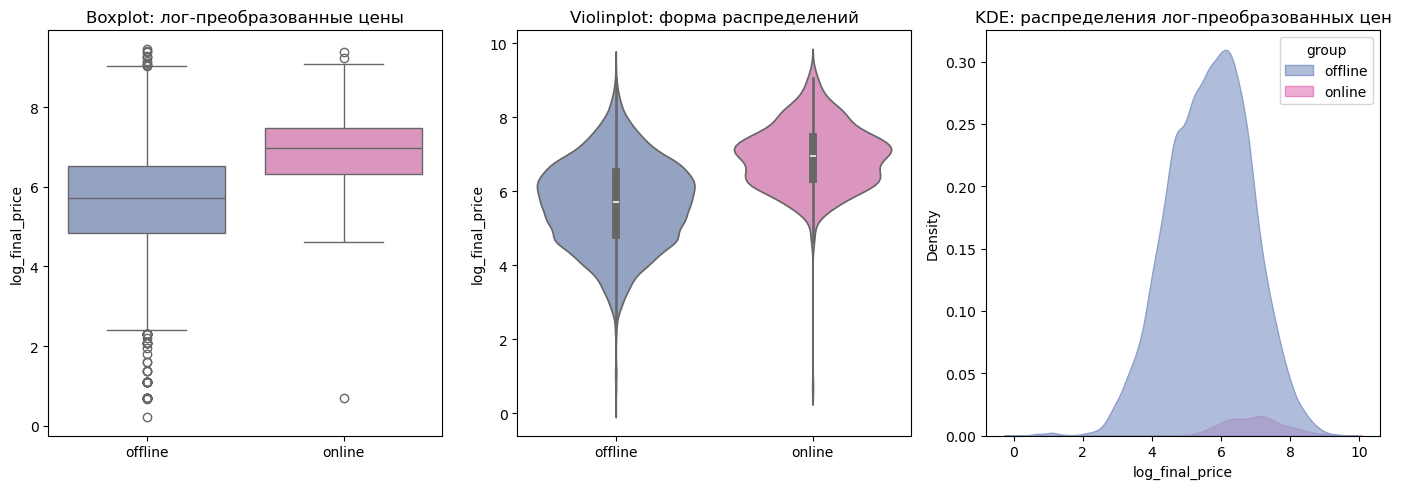

In [8]:
# Берём палитру Set2 и выбираем нужные оттенки
# 2 — голубой (#8DA0CB), 3 — розовый (#FC8D62)
palette = [sns.color_palette("Set2")[2], sns.color_palette("Set2")[3]]
palette_dict = {"offline": palette[0], "online": palette[1]}

# Подготовка данных
offline_log = grouped.loc[grouped["dr_vzak"] == 1, "log_final_price"]
online_log = grouped.loc[grouped["dr_vzak"] == 2, "log_final_price"]

# Формируем DataFrame для визуализаций
plot_df = pd.DataFrame({
    "log_final_price": pd.concat([offline_log, online_log], ignore_index=True),
    "group": (["offline"] * len(offline_log)) + (["online"] * len(online_log))
})

# === Графики ===
fig, axes = plt.subplots(1, 3, figsize=(14, 5))

# 1. -- Boxplot
sns.boxplot(data=plot_df, x="group", y="log_final_price", hue="group",
            palette=palette_dict, ax=axes[0], legend=False)
axes[0].set_title("Boxplot: лог-преобразованные цены")
axes[0].set_xlabel("")
axes[0].set_ylabel("log_final_price")

# 2. -- Violinplot
sns.violinplot(data=plot_df, x="group", y="log_final_price", hue="group",
               palette=palette_dict, ax=axes[1], legend=False)
axes[1].set_title("Violinplot: форма распределений")
axes[1].set_xlabel("")
axes[1].set_ylabel("log_final_price")

# 3. -- KDE plot
sns.kdeplot(data=plot_df, x="log_final_price", hue="group", ax=axes[2],
            palette=palette_dict, fill=True, alpha=0.7)
axes[2].set_title("KDE: распределения лог-преобразованных цен")
axes[2].set_xlabel("log_final_price")
axes[2].set_ylabel("Density")

plt.tight_layout()
plt.show()

Для более детального визуального сравнения форм распределений финальной цены в группах, разделённых по признаку наличия скидки, целесообразно построить ядерные оценки плотности (KDE) для каждой группы отдельно.  
Объединённый график затрудняет интерпретацию из-за различий в масштабе и плотности пиков, что мешает точной оценке различий в форме распределений. Построение отдельных KDE-графиков позволит более наглядно сравнить симметрию, ширину, наличие мод и хвостов каждого распределения, а также даст возможность более обоснованно оценить применимость непараметрических методов статистического анализа, таких как тест Манна – Уитни.  

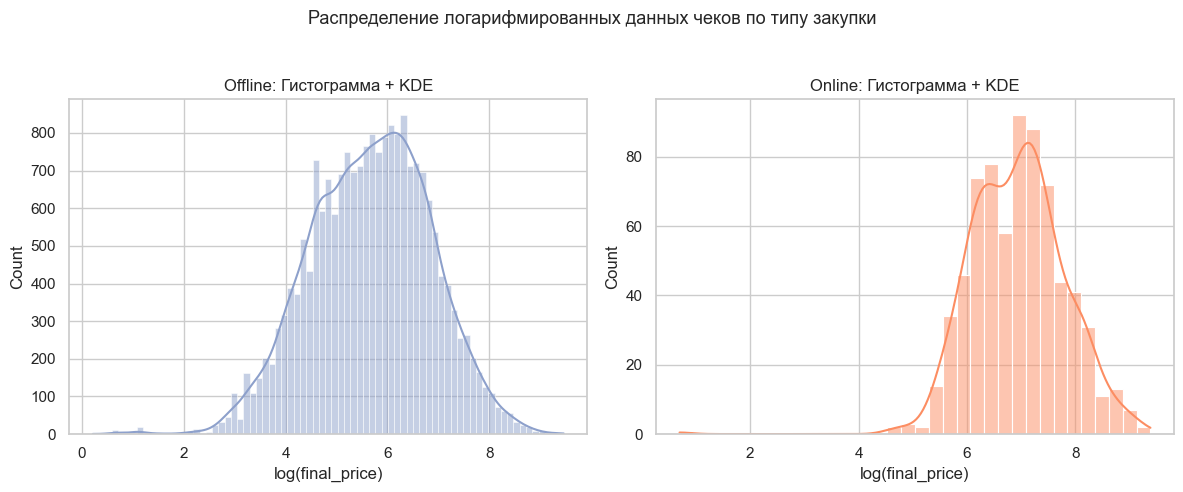

In [9]:
# Настройки стиля
sns.set(style="whitegrid")

# Создание фигуры
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Распределение логарифмированных данных чеков по типу закупки", fontsize=13)

# Гистограмма + KDE для Offline
sns.histplot(offline_log, kde=True, ax=axes[0], color='#8DA0CB') #steelblue
axes[0].set_title("Offline: Гистограмма + KDE")
axes[0].set_xlabel("log(final_price)")

# Гистограмма + KDE для Online
sns.histplot(online_log, kde=True, ax=axes[1], color='#FC8D62') #orange
axes[1].set_title("Online: Гистограмма + KDE")
axes[1].set_xlabel("log(final_price)")

# Плотная компоновка
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Формы распределений в целом схожи: оба графика демонстрируют унимодальность, плавные контуры KDE и отсутствие выраженных скачков или резких переходов. Однако распределение для онлайн-покупок обладает большей "тяжестью хвостов" и менее выраженной симметрией. 
Оба лог-преобразованных распределения в целом близки к нормальному:   
- offline_log — практически нормальное,   
- online_log — с небольшим отрицательным перекосом и выраженными хвостами.    

In [10]:
# Проверка скоса (skewness) и эксцесса (kurtosis)
print("Skew offline_log:", skew(offline_log))
print("Kurtosis offline_log:", kurtosis(offline_log))
print("Skew online_log:", skew(online_log))
print("Kurtosis online_log:", kurtosis(online_log))

Skew offline_log: -0.1614141048564072
Kurtosis offline_log: -0.034098606128046605
Skew online_log: -0.3593185941842183
Kurtosis online_log: 3.3231643511672333


**Интерпретация результатов**     
Распределения логарифмированных данных демонстрируют приближение к нормальному распределению, однако сохраняются незначительные отклонения.  
- Offline-покупки характеризуются умеренной симметрией (skew = -0.16) и близким к нормальному уровнем эксцесса (kurtosis = -0.03). График KDE показывает лёгкий перекос влево и однородную форму с одним выраженным пиком. Это указывает на почти нормальное распределение, незначительно скошенное в сторону меньших значений.  
- Online-покупки имеют более выраженную отрицательную асимметрию (skew = -0.36) и лептокуртическую форму (kurtosis = 3.32), что отражается в визуально более вытянутых хвостах и более остром пике на KDE-графике. Наблюдается тенденция к наличию нескольких локальных максимумов, что может свидетельствовать о гетерогенности данных или наличии подгрупп.  

### Проверка пердпосылок

С учетом результатов визуального анализа и примененного лог-преобразования, можно сделать вывод, что оба распределения достаточно близки к нормальному для проведения Welch t-теста, который устойчив к умеренным отклонениям от нормальности и допускает различие дисперсий между группами.

### Проведение теста

In [11]:
# 1. Welch’s t-test
t_stat, p_val = stats.ttest_ind(offline_log, online_log, equal_var=False)
print("=== Welch t-test (log-преобразованные данные) ===")
print(f"t-статистика: {t_stat:.4f}, p-значение: {p_val:.4e}")


# 2. Cohen's d (размер эффекта для t-теста)
mean_diff = np.mean(offline_log) - np.mean(online_log)
pooled_std = np.sqrt(((offline_log.std() ** 2) + (online_log.std() ** 2)) / 2)
cohen_d = mean_diff / pooled_std
print("\n=== Cohen's d ===")
print(f"Cohen's d: {cohen_d:.3f}")

=== Welch t-test (log-преобразованные данные) ===
t-статистика: -38.3145, p-значение: 5.1742e-184

=== Cohen's d ===
Cohen's d: -1.233


## Mann–Whitney U test

### Проверка предпосылок

Логарифмированные распределения итоговой цены по типу закупки демонстрируют схожую форму, унимодальность и ограниченные отклонения от симметрии. Учитывая близость форм распределений, а также несоблюдение строгой нормальности (особенно для онлайн-покупок), применение непараметрического критерия Манна–Уитни является обоснованным и статистически корректным для сравнения центральных тенденций между группами.  

### Проведение теста

In [12]:
# Лог-преобразование не искажает порядок наблюдений и может быть использовано для устойчивости при наличии выбросов.
# 1. Mann–Whitney U test
u_stat, p_val_u = stats.mannwhitneyu(offline_log, online_log, alternative="two-sided")
print("\n=== Mann–Whitney U test ===")
print(f"U-статистика: {u_stat:.4f}, p-значение: {p_val_u:.4e}")

# 2. Cliff’s Delta (размер эффекта для непараметрического теста)
def cliffs_delta(x, y):
    n_x, n_y = len(x), len(y)
    more = sum(xx > yy for xx in x for yy in y)
    less = sum(xx < yy for xx in x for yy in y)
    delta = (more - less) / (n_x * n_y)
    return delta

delta = cliffs_delta(offline_log, online_log)

# Интерпретация Cliff’s Delta
def interpret_cliffs(delta):
    delta_abs = abs(delta)
    if delta_abs < 0.147:
        return "negligible"
    elif delta_abs < 0.33:
        return "small"
    elif delta_abs < 0.474:
        return "medium"
    else:
        return "large"

print("\n=== Cliff’s Delta ===")
print(f"δ = {delta:.3f}, effect size = {interpret_cliffs(delta)}")


=== Mann–Whitney U test ===
U-статистика: 2779566.5000, p-значение: 3.7274e-172

=== Cliff’s Delta ===
δ = -0.615, effect size = large


**Результаты:**

Статистический анализ:  
Welch’s t-test (на лог-преобразованных данных)
- t = −38.31, p = 5.17 × 10⁻¹⁸⁴
Mann–Whitney U test
- U = 2 779 566.5, p = 3.73 × 10⁻¹⁷²
Оба теста (параметрический и непараметрический) подтверждают статистически значимое различие между типами закупок (p ≪ 0.001).

Размер эффекта
- Cohen’s d = −1.23 (large)
- Cliff’s δ = −0.615 (large)
Отрицательный знак указывает, что средний чек выше у онлайн-заказов, чем у офлайн-заказов.

Онлайн-заказы имеют значительно более высокий средний и медианный чек по сравнению с офлайн-покупками. Различие не только статистически значимо, но и практически значимо — размер эффекта большой (Cohen’s d ≈ 1.2, Cliff’s δ ≈ 0.6).  
Это говорит о том, что формат онлайн-заказов привлекает покупателей, совершающих крупные целевые покупки, тогда как офлайн-покупки чаще носят мелкий или импульсивный характер.  

**Значение для бизнеса:**   
Проведённые статистические тесты подтвердили, что различие среднего чека между онлайн- и офлайн-продажами статистически значимо и эффект большой (|d| > 1), что говорит о системном влиянии формата покупки.   
- Онлайн-канал демонстрирует высокий средний чек и может быть ключевым драйвером выручки при относительно небольшом количестве заказов.     
- Офлайн-точки приносят больший объём продаж по количеству транзакций, но с низким средним чеком.  
- Стратегически важно рассматривать эти каналы в связке, а не в конкуренции — каждый выполняет свою роль в структуре продаж.  

**Рекомендации**   
Основной потенциал роста среднего чека в офлайн-сегменте лежит в управлении поведением покупателя, а не только в ценовых инструментах. Целесообразно сконцентрировать усилия на создании комплексного клиентского опыта в аптеке — сочетание ассортимента, визуальной среды, коммуникации и персонализации. Это позволит снизить разрыв с онлайн-каналом и устойчиво увеличить средний чек без прямого давления скидками.
1. Развивать онлайн-канал как высокомаржинальный сегмент, с акцентом на удобство оформления и ассортимент товаров с высокой ценой.
2. Повысить средний чек в офлайн-магазинах, используя:
- механики "комбо-наборов"¹ и апселлинга;
- персонализированные скидки при достижении порога суммы (по аналогии с онлайн);
- визуальное стимулирование² (товары-сопутствия, аптечные наборы).
3. Сегментировать аудиторию онлайн-покупателей — определить, какие категории и бренды чаще входят в крупные заказы, и использовать эти данные для таргетированных кампаний.
4. При анализе эффективности сотрудников, поставщиков и аптек учитывать, что тип закупки — сильный фактор, влияющий на размер чека.

*Комментарии к использованным терминам*

Результаты анализа показали, что онлайн-заказы имеют существенно более высокий средний чек, чем покупки в аптеке.
Это может быть связано с тем, что онлайн-покупатель чаще делает осознанный, комплексный заказ (на несколько позиций сразу), тогда как офлайн-покупки носят импульсивный и локальный характер.
Чтобы сократить этот разрыв и повысить эффективность розничных аптек, можно использовать механики, усиливающие структуру и привлекательность офлайн-покупок.
Механики вроде комбо-наборов и визуального стимулирования позволяют приблизить офлайн-поведение к онлайн, создавая ощущение удобства, продуманности и выгоды, присущее интернет-покупкам.  

1. Механики «комбо-наборов»

Суть: формирование тематических наборов взаимодополняющих товаров, продаваемых вместе по специальной цене.
Такие решения стимулируют покупателя увеличить количество позиций в чеке и воспринимаются как забота о клиенте и удобство выбора.

Примеры аптечных комбо-наборов:

| Категория        | Пример набора                                    | Цель                                                 |
| ---------------- | ------------------------------------------------ | ---------------------------------------------------- |
| При простуде     | жаропонижающее + витамины + спрей для горла      | Повышение среднего чека за счёт комплексного решения |
| Для родителей    | жаропонижающее + антисептик + детские пластыри   | Поддержка повторных и семейных покупок               |
| Для красоты      | витамины для волос + шампунь + маска             | Рост cross-sell через сопутствующие товары           |
| В дорогу         | обезболивающее + активированный уголь + пластыри | Увеличение сезонных и импульсных покупок             |


Бизнес-эффект:   
Рост среднего чека на 10–25% за счёт кросс-продаж.   
Снижение времени принятия решения клиентом.   
Повышение воспринимаемой ценности бренда аптеки.  

2. Визуальное стимулирование и мерчандайзинг

Суть: оформление торгового пространства и расположение товаров так, чтобы побудить клиента к дополнительным покупкам.
Используются поведенческие принципы — внимание, доступность, напоминание о потенциальной потребности.

Примеры:

| Зона                        | Пример реализации                                              | Поведенческий эффект                       |
| --------------------------- | -------------------------------------------------------------- | ------------------------------------------ |
| **Кассовая зона**           | Витамины, пластыри, чай при простуде, леденцы                  | «Добавление по пути» (impulse buy)         |
| **Сезонные стенды**         | «Готовься к осени», «Сезон аллергии»                           | Напоминание о возможной нужде              |
| **Сопутствующие товары**    | Рядом с антибиотиками — пробиотики, рядом с тестами — витамины | Формирует доверие и ощущение заботы        |
| **Готовые аптечки**         | Упакованные наборы «В дорогу», «Для семьи», «Домашняя аптечка» | Упрощает выбор и усиливает ощущение выгоды |


Бизнес-эффект:   
Повышение вероятности импульсных покупок до +15%.  
Усиление восприятия аптеки как эксперта, заботящегося о клиенте.    
Снижение зависимости среднего чека от скидочных акций.  

Рекомендации для внедрения  
1. Внедрить мониторинг “составов чеков” — анализировать, какие группы товаров часто встречаются вместе.  
2. Создать линейку комбо-наборов под ключевые клиентские сценарии (ОРВИ, уход, путешествия и т.п.).  
3. Оптимизировать визуальную выкладку: сопутствующие товары должны быть расположены физически рядом.  
4. Использовать аналитику продаж для A/B-тестов — измерять изменение среднего чека после внедрения наборов или новых мерчандайзинговых решений.  